In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import kernel_ridge
import random
import itertools

## Import Data Set

In [2]:
# Get naive and actual occupancy percentage data
X_data = pd.read_csv('X_data.csv')
X_data = np.array(X_data.values.tolist())
X_data = X_data[:,3]
print('Naive occupancy')
print(X_data[0:10])

Y_data = pd.read_csv('Y_data.csv')
Y_data = np.array(Y_data.values.tolist())
Y_data = Y_data[:,1]
print('Actual occupancy')
print(Y_data[0:10])

Naive occupancy
[0.286 0.286 0.321 0.321 0.321 0.321 0.321 0.357 0.357 0.357]
Actual occupancy
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]


In [5]:
# Group data into blocks
blocks_X = np.reshape(X_data, (12,7,720))
blocks_Y = np.reshape(Y_data, (12,7,720))
print('Naive occupancy')
print(blocks_X[0,0,:10])
print('Actual occupancy')
print(blocks_Y[0,0,:10])

Naive occupancy
[0.286 0.286 0.321 0.321 0.321 0.321 0.321 0.357 0.357 0.357]
Actual occupancy
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]


In [6]:
# Get block names label for each of X/Y data
block_names = pd.read_csv('block_names.csv')
block_names = np.array(block_names.iloc[:,1])
block_names = np.reshape(block_names, (12,7))
print(block_names[0])

['11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST 2022/03/21'
 '11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST 2022/03/22'
 '11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST 2022/03/23'
 '11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST 2022/03/24'
 '11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST 2022/03/25'
 '11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST 2022/03/26'
 '11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST 2022/03/28']


## Correlated Blocks

In [219]:
print("Highly correlated blocks:")
print(block_names[0][0][:45])
print(block_names[4][0][:39])
print(block_names[7][0][:43])
print(block_names[11][0][:45])

corr_blocks = np.vstack((block_names[0], block_names[4], block_names[7], block_names[11]))
corr_x = np.vstack((blocks_X[0], blocks_X[4], blocks_X[7], blocks_X[11]))
corr_y = np.vstack((blocks_Y[0], blocks_Y[4], blocks_Y[7], blocks_Y[11]))

Highly correlated blocks:
11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST
6TH AVE N BETWEEN JOHN ST AND THOMAS ST
EASTLAKE AVE E BETWEEN ALOHA ST AND WARD ST
ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N


In [220]:
lambda_val = 0.1
gamma = 0.001

rrg = kernel_ridge.KernelRidge(alpha=lambda_val, kernel='rbf', gamma=gamma)

In [233]:
rand_sample = random.sample(range(28), 5)

In [234]:
x_test = []
y_test = []
name_test = []
corr0_x = np.copy(corr_x)
corr0_y = np.copy(corr_y)
for i in rand_sample:
    x_test.append(corr0_x[i])
    y_test.append(corr0_y[i])
    index_block = int(i/7)
    index_day = i%7
    name_test.append(corr_blocks[index_block][index_day])
    
corr0_x = np.delete(corr0_x, rand_sample, axis=0)
corr0_y = np.delete(corr0_y, rand_sample, axis=0)

In [235]:
print("Test Blocks:")
for i in range(5):
    print(name_test[i])

Test Blocks:
11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST 2022/03/24
EASTLAKE AVE E BETWEEN ALOHA ST AND WARD ST 2022/03/26
6TH AVE N BETWEEN JOHN ST AND THOMAS ST 2022/03/21
6TH AVE N BETWEEN JOHN ST AND THOMAS ST 2022/03/28
11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST 2022/03/22


In [236]:
rrg.fit(corr0_x, corr0_y)
prediction = rrg.predict(x_test)

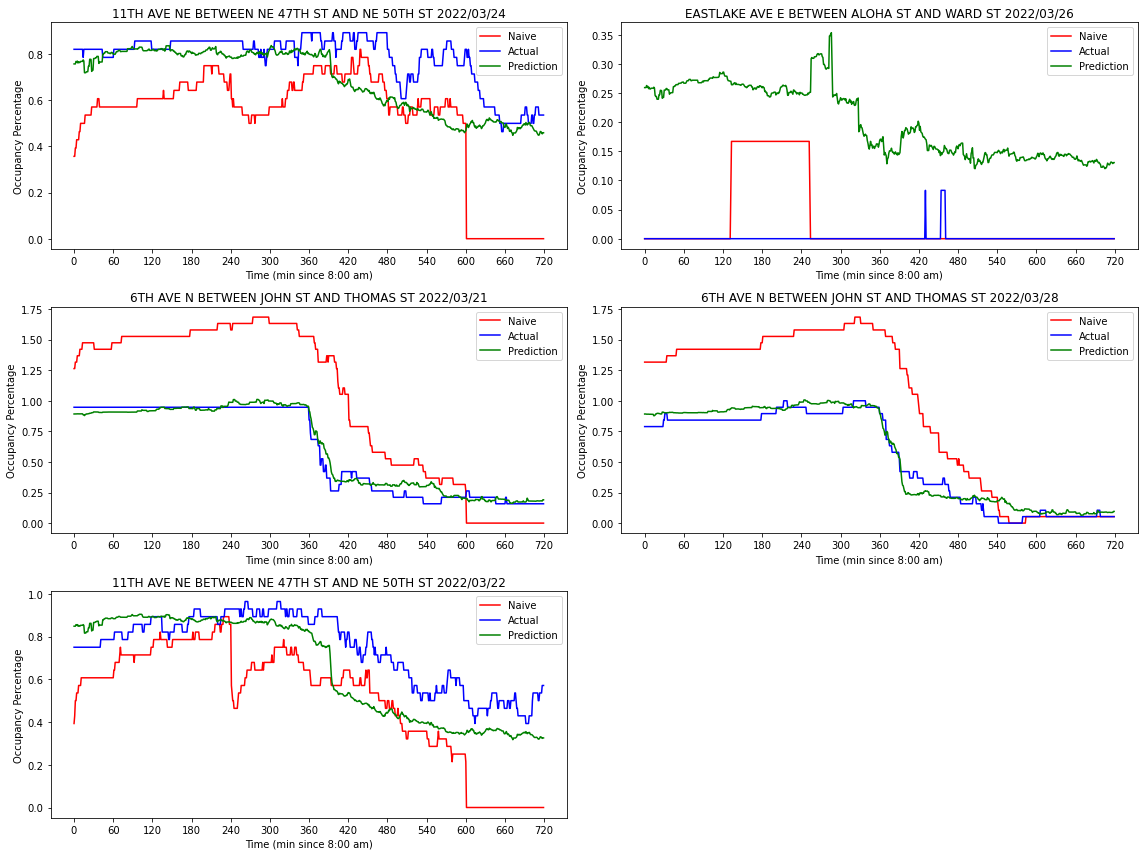

Prediction MAE:
0.10643887909365173
Naive MAE:
0.28439555555555557


In [279]:
time = np.arange(720)
test_mae = 0
naive_mae = 0

plt.figure(figsize=(16,12))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.plot(time, x_test[i], color='r', label='Naive')
    plt.plot(time, y_test[i], color='b', label='Actual')
    plt.plot(time, prediction[i], color='g', label='Prediction')
    plt.legend()
    plt.xlabel('Time (min since 8:00 am)')
    plt.xticks(np.arange(0,780,60))
    plt.ylabel('Occupancy Percentage')
    plt.title(name_test[i])
    test_mae += np.mean(np.abs(y_test[i]-prediction[i]))
    naive_mae += np.mean(np.abs(y_test[i]-x_test[i]))
plt.tight_layout()
plt.show()

print("Prediction MAE:")
print(test_mae/5)
print("Naive MAE:")
print(naive_mae/5)

## Test 11th Ave Correlation

In [280]:
def display(x, y, prediction, name):
    time = np.arange(720)
    test_mae = 0
    naive_mae = 0

    plt.figure(figsize=(20,16))
    for i in range(7):
        plt.subplot(4, 2, i+1)
        plt.plot(time, x[i], color='r', label='Naive')
        plt.plot(time, y[i], color='b', label='Actual')
        plt.plot(time, prediction[i], color='g', label='Prediction')
        plt.legend()
        plt.xlabel('Time (min since 8:00 am)')
        plt.xticks(np.arange(0,780,60))
        plt.ylabel('Occupancy Percentage')
        plt.title(name[i])
        test_mae += np.mean(np.abs(y[i]-prediction[i]))
        naive_mae += np.mean(np.abs(y[i]-x[i]))
    plt.tight_layout()
    plt.show()

    print("Prediction MAE:")
    print(test_mae/5)
    print("Naive MAE:")
    print(naive_mae/5)

In [286]:
corr1_x = np.vstack((blocks_X[4], blocks_X[7], blocks_X[11]))
x_test1 = blocks_X[0]
corr1_y = np.vstack((blocks_Y[4], blocks_Y[7], blocks_Y[11]))
y_test1 = blocks_Y[0]

In [287]:
rrg.fit(corr1_x, corr1_y)
prediction1 = rrg.predict(x_test1)

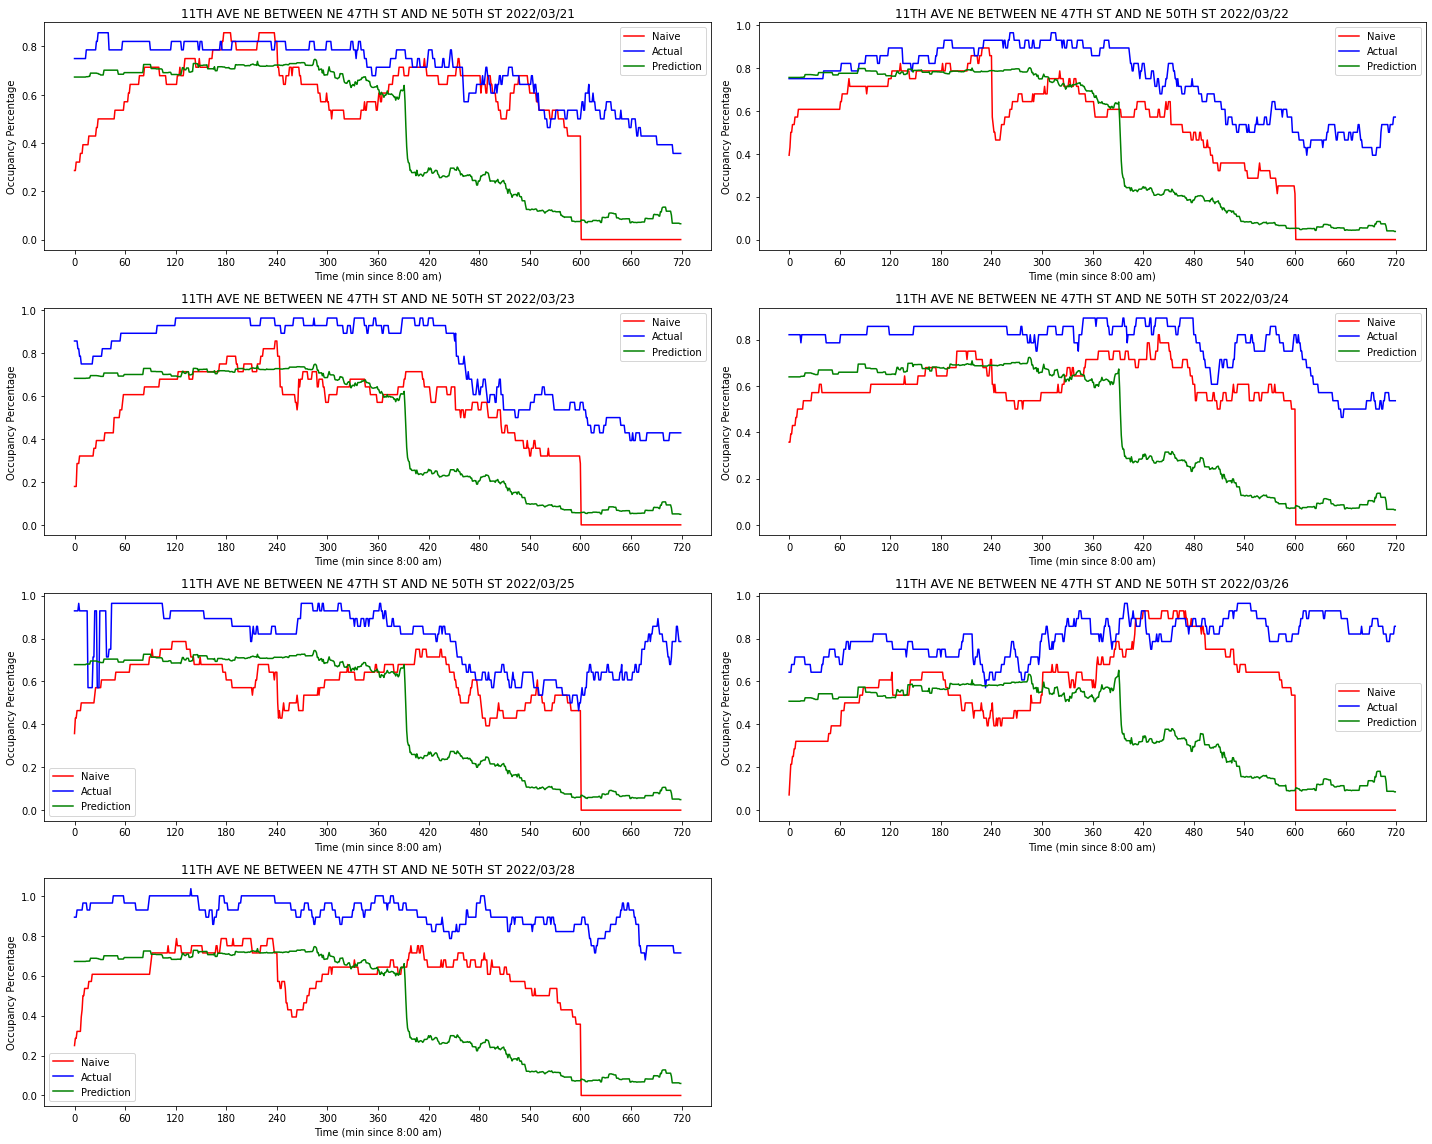

Prediction MAE:
0.4831552766311888
Naive MAE:
0.3933041666666667


In [288]:
display(x_test1, y_test1, prediction1, block_names[0])

## Test 6th Ave Correlation

In [303]:
corr2_x = np.vstack((blocks_X[7], blocks_X[11]))
x_test2 = blocks_X[4]
corr2_y = np.vstack((blocks_Y[7], blocks_Y[11]))
y_test2 = blocks_Y[4]

In [304]:
rrg.fit(corr2_x, corr2_y)
prediction2 = rrg.predict(x_test2)

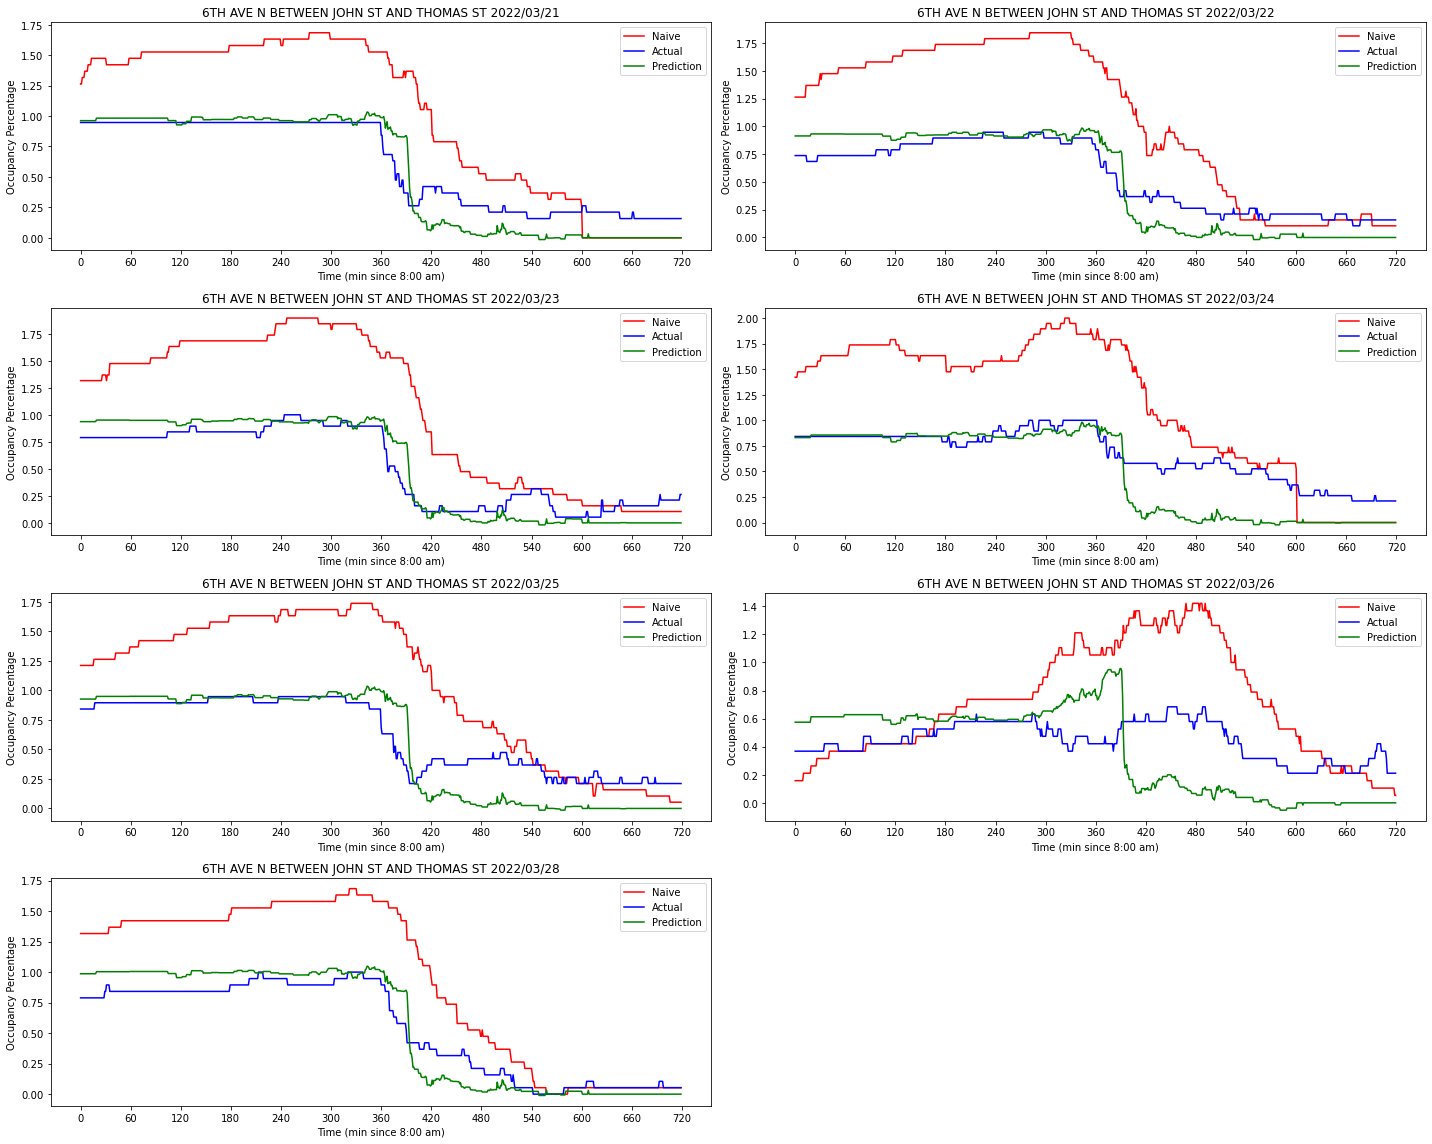

Prediction MAE:
0.22330092502431387
Naive MAE:
0.6740444444444444


In [305]:
display(x_test2, y_test2, prediction2, block_names[4])

## Test EastLake Ave

In [300]:
corr3_x = np.vstack((blocks_X[4], blocks_X[11]))
x_test3 = blocks_X[7]
corr3_y = np.vstack((blocks_Y[4], blocks_Y[11]))
y_test3 = blocks_Y[7]

In [301]:
rrg.fit(corr3_x, corr3_y)
prediction3 = rrg.predict(x_test3)

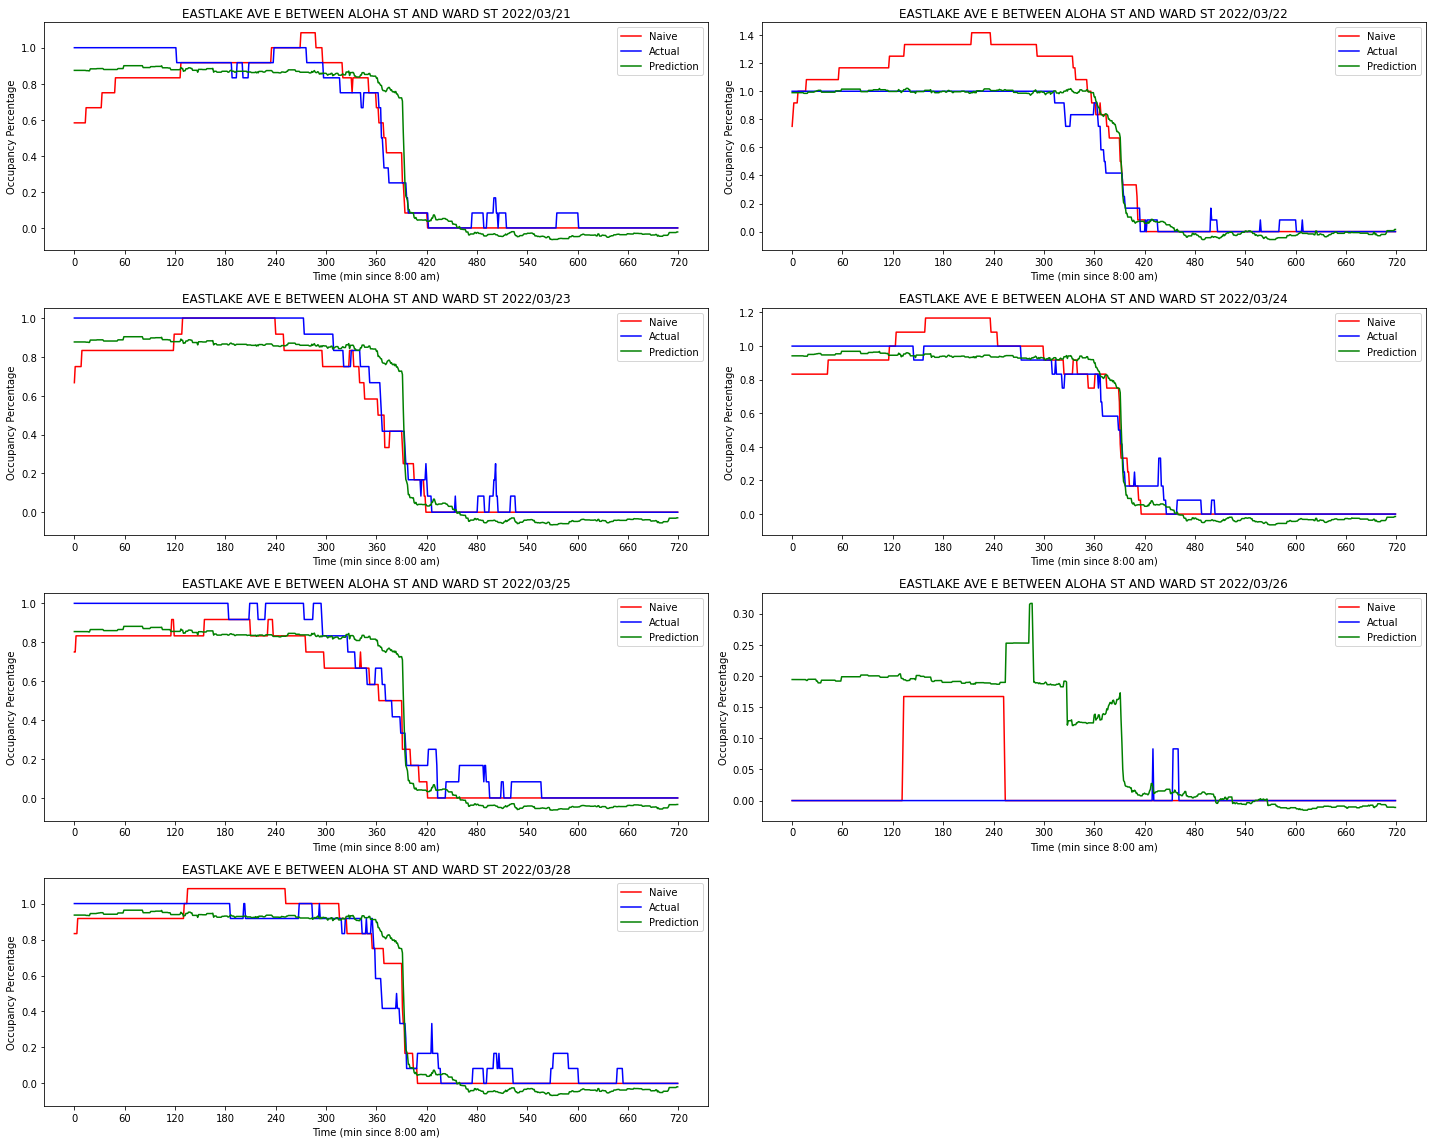

Prediction MAE:
0.11432883587096772
Naive MAE:
0.1070788888888889


In [302]:
display(x_test3, y_test3, prediction3, block_names[7])

## Test Roy St

In [297]:
corr4_x = np.vstack(( blocks_X[4], blocks_X[7]))
x_test4 = blocks_X[11]
corr4_y = np.vstack(( blocks_Y[4], blocks_Y[7]))
y_test4 = blocks_Y[11]

In [298]:
rrg.fit(corr4_x, corr4_y)
prediction4 = rrg.predict(x_test4)

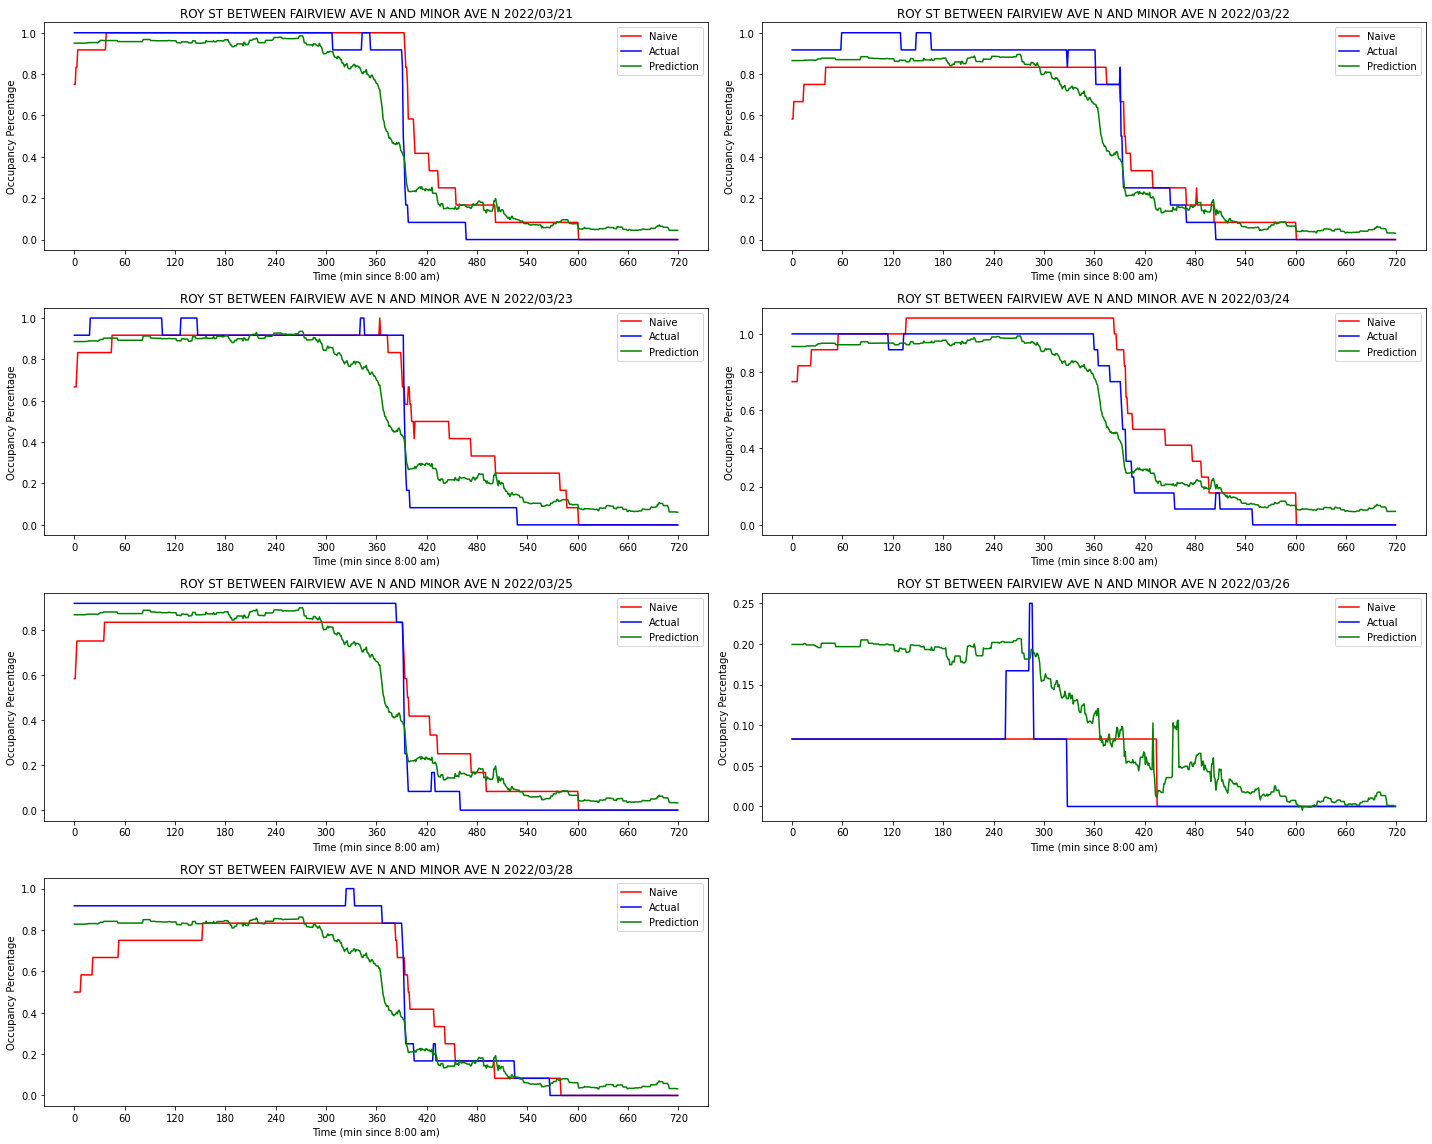

Prediction MAE:
0.1186965079379971
Naive MAE:
0.11228027777777778


In [299]:
display(x_test4, y_test4, prediction4, block_names[11])